In [70]:
# Import the required libraries
import warnings
warnings.filterwarnings("ignore")

from utils import *

Maintenant qu'on a les bonnes variables à mettre dans notre modèle, on va désormais chercher les meilleurs paramètres de notre modèle.

Mais avant vérifions si on overfit ou pas

In [32]:
utils.overfit(['roc_auc', 'accuracy', "recall", 'precision', 'f1'], X_train, y_train ).round(3)

Mean Auc: 0.88
Gini: 0.76


,fit_time,score_time,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1
0,0.017,0.009,0.887,0.882,0.864,0.868,0.492,0.522,0.717,0.721,0.583,0.606
1,0.015,0.008,0.859,0.889,0.862,0.872,0.497,0.535,0.702,0.733,0.582,0.618
2,0.017,0.008,0.855,0.890,0.856,0.870,0.486,0.528,0.682,0.726,0.568,0.611
3,0.016,0.008,0.915,0.875,0.875,0.866,0.524,0.498,0.758,0.723,0.620,0.590
4,0.014,0.008,0.893,0.881,0.873,0.867,0.560,0.509,0.720,0.722,0.630,0.597
5,0.015,0.008,0.897,0.880,0.883,0.866,0.492,0.501,0.835,0.723,0.619,0.592
6,0.015,0.008,0.883,0.883,0.867,0.870,0.514,0.518,0.720,0.734,0.599,0.607
7,0.015,0.008,0.897,0.879,0.866,0.868,0.578,0.506,0.682,0.729,0.626,0.597
8,0.016,0.008,0.867,0.887,0.847,0.871,0.481,0.536,0.640,0.724,0.549,0.616
9,0.018,0.008,0.860,0.889,0.865,0.871,0.489,0.536,0.720,0.724,0.583,0.616


On remarque qu'en utilisant la méthode des K-Folds avec k=10, le modèle est capable de généraliser ses performances. En effet les performances dans le train et le test sont très proches, le modèle n'overfitte pas.

Cherchons maintenant les meilleurs paramètres par la méthode du GridSearchCV

In [33]:
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 
           'Recall': make_scorer(recall_score), 'f1_score': make_scorer(f1_score),
          'Precision': make_scorer(precision_score)}

param={"penalty":["l2", "l1", "elasticnet"], 
       'C':[5,10,15,20], 
       "max_iter":[100,150,200]}

gs = GridSearchCV(LogisticRegression(random_state=42),
                  param_grid=param,
                  scoring=scoring, refit='AUC', return_train_score=True, cv = 5)

gs.fit(X_train, y_train)
results = gs.cv_results_

print("Les meilleurs paramètres sont:", gs.best_params_)
print("Le meilleur score est: %.2f" %gs.best_score_)

Les meilleurs paramètres sont: {'C': 15, 'max_iter': 100, 'penalty': 'l2'}
Le meilleur score est: 0.89


On peut maintenant évaluer les performances de notre modèle en prenant de rééchantilloner notre dataset.

SMOTE
--------
train score 0.81
--------
test score 0.80
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       927
           1       0.50      0.80      0.61       265

    accuracy                           0.78      1192
   macro avg       0.71      0.78      0.73      1192
weighted avg       0.83      0.78      0.79      1192



Matrice de confusion

[[716 211]
 [ 54 211]]
--------
L'AUC est de 0.88
--------
Gini test: 0.75
--------
Gini train: 0.77
--------
roc curve


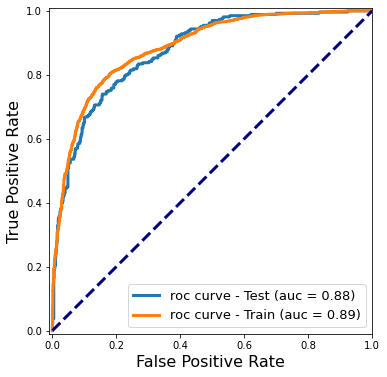



precision_recall_curve


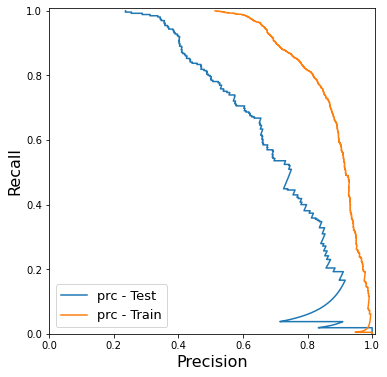

Meilleur cut-off test : 0.08
Meilleur cut-off train : 0.12


In [34]:
train_pred, y_test, test_pred, fpr, tpr, roc_auc = utils.model_perf(X_train, y_train, X_test, y_test, smote = True, show_roc= True, show_prc=True, cut_off= 0.45, show_conf_matrix=True)

On a un recall très élevé et une précision très faible. Même si notre problème est orienté recall, on préfère garder un certain équilibre entre ces 2 métriques afin d'avoir un f1 score appréciable.

Dans notre cas, on a procédé par tâtonnement et puis fixé ce cutoff à 0,45. Toutes les observations dont la probabilité prédite est supérieure à ce seuil doivent être classées dans la catégorie Défaut (classe 1) et Non Défaut (Classe 0) sinon.

## ***5 - SCORECARD***

Notre Grille de score est calibrée sur 1000 points, plus le score est élevé, moins le client a de risque de faire défaut. On fixe les Odds à $\frac{1}{500}$ (500:1) et les PDO (Points Double the Odds) à 30 points. 

Ainsi une personne qui a un  score 1000 points  a une probabilité de défaut de 1/500 alors qu'une personne qui a un score de 1030 (1000 + 30) elle a une une probabilité de défaut égale à $\frac{1}{1000}$ (1000:1 = 2*500:1).

En pratique, la Grille de score est déterminée de la façon suivante :

- On détermine la probabilité de défaut $p(y=1)$ par : 

    $\begin{equation}
       p(y=1) =  \frac{1}{1+exp(-Z)} 
    \end{equation}$
avec z qui est la combinaison linéaire des WOE de toutes les variables sélectionnées en entrée 

 $\begin{equation}
    Z   =  b_0 + b_1*WOE_1 + b_2*WOE_2+ ... +b_k*WOE_k 
\end{equation}$
$\begin{equation}
    Z =  log(\frac{p}{1-p})
    \end{equation}$

Mais comme on sait que :  
    $\begin{equation}
        Odds   =  \frac{p}{1-p} 
    \end{equation}$
donc
    $\begin{equation}
        Z  = log(Odds)
    \end{equation}$
- Ensuite on va directement déterminer les points par les formules suivantes : 
    $\begin{equation}
    Points   =  Shift + Slope*Z
    \end{equation}$
    $\begin{equation}
    Points + PDO  =  Shift + Slope*log(2*Odds)
    \end{equation}$
RQ : Le PDO est positif pour garantir le fait que les scores les plus élevés engendrent les risques les plus faibles.

In [88]:
def scoring(X, base = 1000, pdo = 30):
    
    #CREATION DE LA GRILLE SCORE À PARTIR DES CLASSES, DU MODÈLE M ET CALIBRAGE SUR "base" POINTS
    lr = LogisticRegression(penalty='l2', C=5, max_iter= 100, random_state=42)
    lr.fit(X_train, y_train)
    test_pred = lr.predict_proba(X_test)[:,1]
    
    ppb = sc.scorecard(classes, lr, xcolumns=X_test.columns, 
                       odds0=1/500,  points0=base, pdo=pdo, basepoints_eq0 = True)
    
    
        #CALCUL DES SCORES TOTAUX DANS LE TRAIN SET
    train_score = sc.scorecard_ply(train, ppb, print_step=0, only_total_score=False)
        #CALCUL DES SCORES DANS LE TEST SET
    test_score = sc.scorecard_ply(test, ppb, print_step=0, only_total_score=False)

    if X == "Test":
        a = test_score
        b = test
    else:
        X == "Train"
        a = train_score
        b = train
        
    score_avec_target = pd.concat([a, b['BAD']],axis=1)
    #score_total       = score_avec_target['score']
    bon_score         = score_avec_target[score_avec_target["BAD"]== 0]['score']
    mauvais_score     = score_avec_target[score_avec_target["BAD"]== 1]['score']


    plt.figure()
    sns.distplot(mauvais_score, color='red', label = "BAD = 1")
    sns.distplot(bon_score, color = "green", label ="BAD = 0" )
    plt.legend(loc='upper left')
    plt.title("score distribution - " + str(X))

        
    plt.figure()
    sns.distplot(train_score["score"], color='blue', label = "train score")
    sns.distplot(test_score["score"], color = "orange", label ="test score" )
    plt.legend(loc='upper left')
    plt.title("Test & Train Comparaison")
    
    return ppb, train_score, test_score

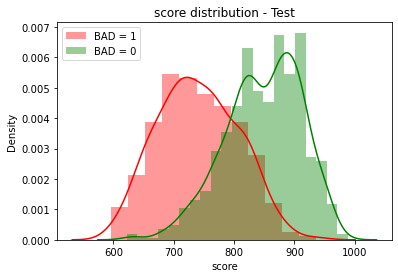

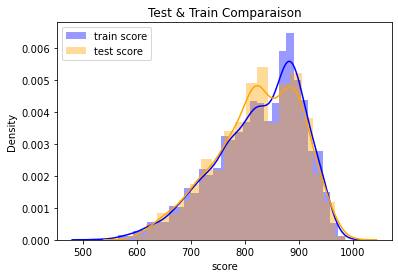

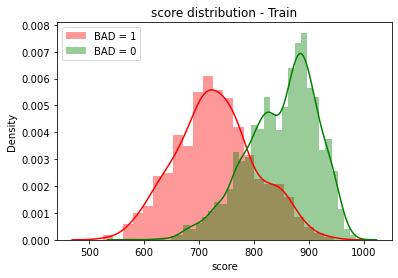

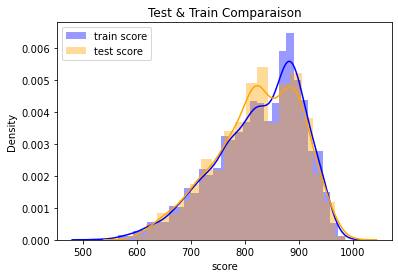

In [89]:
# On détermine les score dans le train et le test set
ppb, train_score, test_score= scoring("Test")
ppb, train_score, test_score= scoring("Train")

In [38]:
test_score.describe()["score"]

count    1192.000000
mean      824.329698
std        77.679569
min       596.000000
25%       772.000000
50%       830.500000
75%       886.000000
max       988.000000
Name: score, dtype: float64

In [39]:
train_score.describe()["score"]

count    4768.000000
mean      826.513633
std        80.741312
min       525.000000
25%       773.000000
50%       839.000000
75%       889.000000
max       986.000000
Name: score, dtype: float64


La contribution de variable j pour l'individu i est donnée par  :

$\begin{equation}
Points_ji = Slope*(b_j*WOE_j(i)).
\end{equation}$

Par défaut, les points de base ne sont pas équi-distribués; dans notre cas on a décidé que les points de base soient également distribués à chaque variable donc: 
$\begin{equation}
Points_ji = \frac{Shift + Slope*b_0}{k + Slope*(b_j*WOE_j(i))}
\end{equation}$
avec k le nombre de variables dans le modèle et $Base points = Shift + Slope*b_0$.

In [40]:
test_score.head()

,JOB_points,CLNO_points,CLAGE_points,LOAN_points,MORTDUE_points,VALUE_points,NINQ_points,YOJ_points,DEROG_points,DELINQ_points,DEBTINC_points,score
8,68.0,81.0,85.0,38.0,64.0,55.0,76.0,62.0,80.0,25.0,35.0,669.0
14,68.0,81.0,55.0,38.0,71.0,70.0,80.0,86.0,80.0,25.0,35.0,689.0
15,68.0,44.0,105.0,38.0,64.0,55.0,80.0,86.0,80.0,25.0,35.0,680.0
17,68.0,69.0,70.0,38.0,64.0,50.0,76.0,70.0,80.0,90.0,129.0,804.0
23,68.0,81.0,55.0,38.0,64.0,50.0,80.0,94.0,80.0,25.0,35.0,670.0


Le dataframe ci-dessus nous donne pour les 5 premiers individus du test set les points que leur confère chaque variable en fonction de leurs caractéristiques et la dernière colonne est leur score cumulé.

In [41]:
ppb

{'basepoints':      variable  bin  points
 0  basepoints  NaN       0,
 'JOB':   variable           bin  points
 0      JOB        Office    90.0
 1      JOB       ProfExe    80.0
 2      JOB   Other%,%Mgr    68.0
 3      JOB  Self%,%Sales    49.0,
 'CLNO':   variable          bin  points
 4     CLNO  [-inf,10.0)    44.0
 5     CLNO  [10.0,21.0)    81.0
 6     CLNO  [21.0,24.0)    69.0
 7     CLNO  [24.0,27.0)    95.0
 8     CLNO  [27.0,39.0)    68.0
 9     CLNO   [39.0,inf)    54.0,
 'CLAGE':    variable            bin  points
 10    CLAGE   [-inf,150.0)    55.0
 11    CLAGE  [150.0,180.0)    70.0
 12    CLAGE  [180.0,240.0)    85.0
 13    CLAGE    [240.0,inf)   105.0,
 'LOAN':    variable                bin  points
 14     LOAN      [-inf,6000.0)    38.0
 15     LOAN    [6000.0,8000.0)    62.0
 16     LOAN   [8000.0,10000.0)    75.0
 17     LOAN  [10000.0,11000.0)    65.0
 18     LOAN  [11000.0,15000.0)    75.0
 19     LOAN  [15000.0,16000.0)    62.0
 20     LOAN  [16000.0,38000.0)  

In [42]:
ppb['VALUE']

,variable,bin,points
29,VALUE,"[-inf,50000.0)",55.0
30,VALUE,"[50000.0,70000.0)",78.0
31,VALUE,"[70000.0,85000.0)",70.0
32,VALUE,"[85000.0,90000.0)",50.0
33,VALUE,"[90000.0,125000.0)",85.0
34,VALUE,"[125000.0,175000.0)",70.0
35,VALUE,"[175000.0,inf)",82.0


Nous allons tester la stabilité des deux distributions de scores dans le train et le test set, on obtient un PSI=0.0162 (PSI : Population Stability Index). L'indice de stabilité de la population (ISP) est utilisé pour mesurer l'applicabilité d'un modèle en mesurant le changement des variables indépendantes ou dépendantes.Il compare la distribution d'une variable de notation (probabilité prédite) dans un ensemble de données de notation à un ensemble de données d'entraînement qui a été utilisé pour développer le modèle. 
L'idée est de vérifier "comment le score actuel est comparé à la probabilité prédite à partir de l'ensemble de données du train set."

Pour chaque variable, on a déterminé la stabilité du taux de défaut pour toutes les classes précédemment créées dans le test et le train. Cette stabilité permet de bien pouvoir généraliser les résultats.

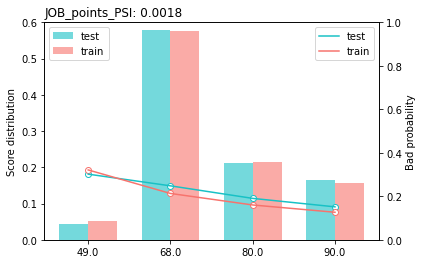

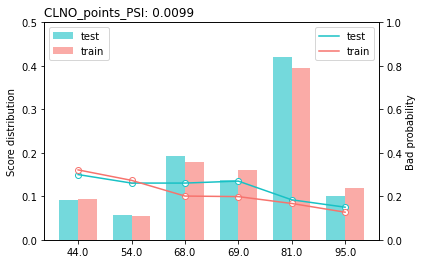

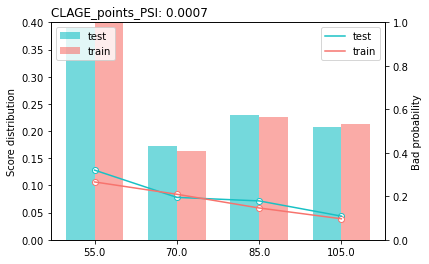

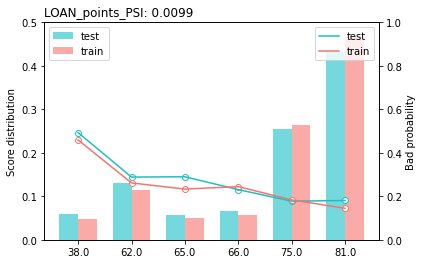

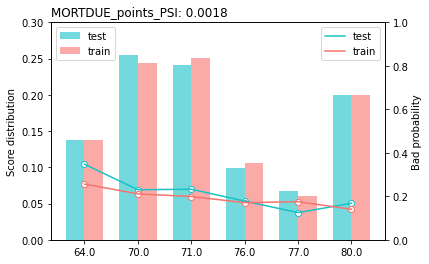

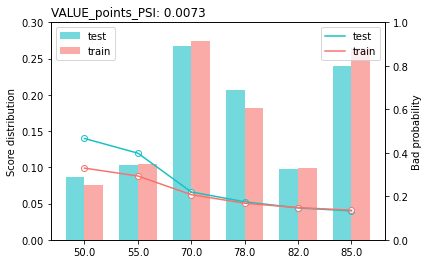

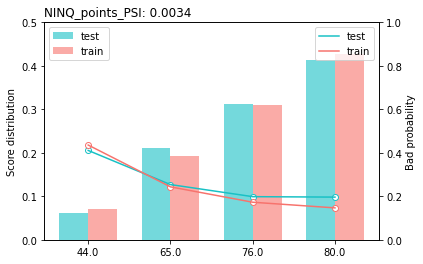

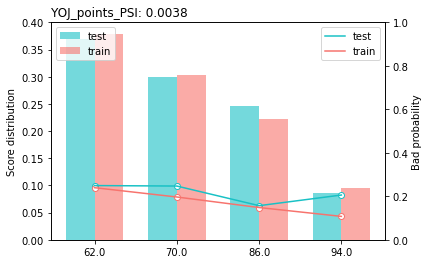

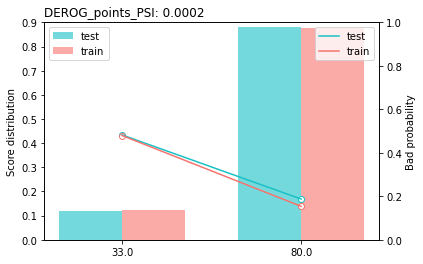

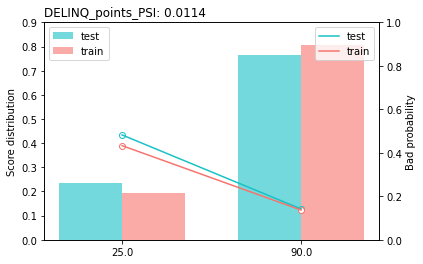

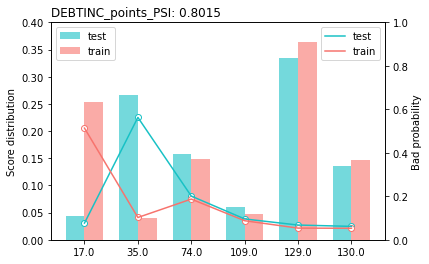

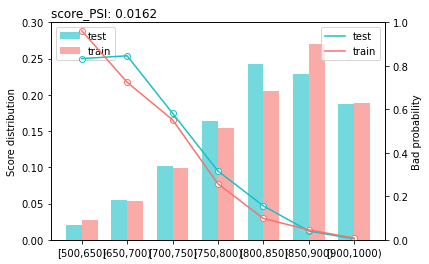

In [44]:
p = sc.perf_psi(score = {'train':train_score, 'test':test_score}, 
        label = {'train':y_train, 'test':y_test},
        return_distr_dat=True)

Toutefois on a vu que pour la variable DEBTINC, on n'a absolument pas de stabilité dans les points délivrés par chaque classe. Mais la Grille de score étant très stable, on considérera cet instabilité comme étant sans grande incidence.

In [80]:
p.keys()

dict_keys(['psi', 'pic', 'dat'])

In [79]:
p["psi"]

,variable,PSI
0,MORTDUE_points,0.001799
1,YOJ_points,0.003823
2,DEBTINC_points,0.801477
3,JOB_points,0.001790
4,VALUE_points,0.007331
5,DEROG_points,0.000166
6,CLAGE_points,0.000723
7,CLNO_points,0.009945
8,LOAN_points,0.009875
9,DELINQ_points,0.011429


La table ci-dessous nous donne notre grille de score finale, il est important de noter que chaque classe de risque correspond à une probabilité de défaut. En effet on observe comme prévu une baisse de la probabilité de défaut lorsque le score augmente. Les individus en bas (en rouge) ne devraient pas voir leur demande acceptée, ceux en haut(en vert) doivent avoir le prêt et ceux en ballottage (en orange) méritent une analyse métier plus approfondie afin de décider.

In [45]:
scorecard_bins = p["dat"]["score"]
scorecard_bins

bin    N         badprob          
ae             test train      test     train
0    [500,650)   24   132  0.833333  0.962121
1    [650,700)   65   254  0.846154  0.724409
2    [700,750)  122   473  0.581967  0.551797
3    [750,800)  196   738  0.316327  0.257453
4    [800,850)  289   979  0.155709  0.098059
5    [850,900)  273  1290  0.040293  0.045736
6   [900,1000)  223   902  0.004484  0.007761

Sur les 1192 individus formant le test set, 75% d'entre eux ont un score inférieur à 886 points, la moyenne étant à 824 et la médiane à 830.5 points. Le plus grand score est de 988 et le plus petit 596. Notons que la volatilité du score est de 78 points.

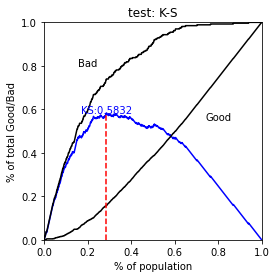

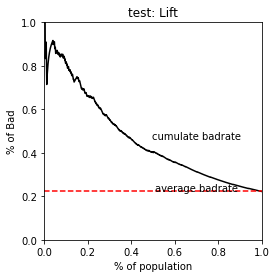

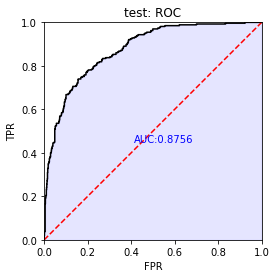

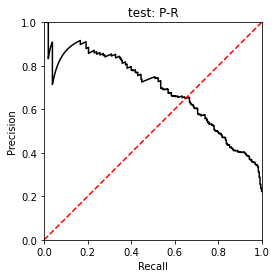

In [46]:
test_perf = sc.perf_eva(y_test, test_pred, title = "test", plot_type=['ks'])
test_perf = sc.perf_eva(y_test, test_pred, title = "test", plot_type=['lift'])
test_perf = sc.perf_eva(y_test, test_pred, title = "test", plot_type=['roc'])
test_perf = sc.perf_eva(y_test, test_pred, title = "test", plot_type=['pr'])